# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import skimage

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


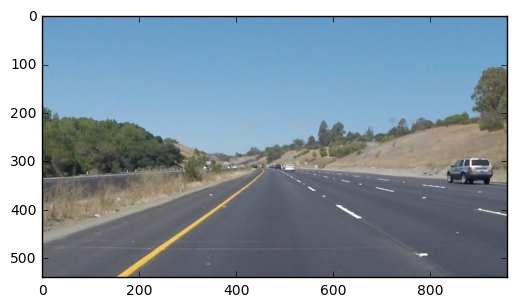

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def skeletonize(img):
    skimage.morphology.skeletonize(img)
    
def equalization(img):
    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Here is how we will proceed on drawing discontinued lane lines
    '''
    First find the slopes of all lines, then divide lines into left and 
    right lane bases on their slope and position. Extrapolate on right and left lines using
    using linear regrssion over lines segments to find the best fit line for
    left and right lane line.
    After finding left and right final lines, we uses the slope and intercept to
    find the end points of the lines and use them to draw the lane lines
    on the output image.
    '''
    
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only retain lines where abs(slope) > threshold
    trap_height = 0.4
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    
    for line in lines:
        x1,y1,x2,y2 =  line[0] # extract start and end points
        
        # Calculate slope
        if x2 - x1 == 0.: # corner case, avoiding divide by zero
            slope = 999. # infinite slope
        else:
            slope = (y2 - y1)/(x2 - x1)
            
        # Filter lines based on slopes
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
    lines = new_lines
    
    # Separate lines into left and right lines based on weither their 
    # respective slope are positive or negative
    r_lines = []
    l_lines = []
    for i, line in enumerate(lines):
        x1,y1,x2,y2 =  line[0] # extract start and end points
        img_x_center = img.shape[1]/2 # x coordinate of the centre of the image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            r_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            l_lines.append(line)
            
    # Interpolate over all line segments to find the best fit of right and 
    # left lane lines
    # Right lines
    r_lines_x = []
    r_lines_y = []
    
    for line in r_lines:
        x1,y1,x2,y2 =  line[0] # extract start and end points
        
        # x coordinates of lines segments in right lines
        r_lines_x.append(x1)
        r_lines_x.append(x2)
        
        # y coordinates of lines segments in right lines
        r_lines_y.append(y1)
        r_lines_y.append(y2)
        
    # use polyfit to run linear regrssion to construct the final line
    if len(r_lines_x) > 0:
        r_m, r_b = np.polyfit(r_lines_x, r_lines_y, 1) # y = x*m + b
    else:
        r_m, r_b = 1, 1
        draw_right = False
        
    # Left lane lines
    l_lines_x = []
    l_lines_y = []
    
    for line in l_lines:
        x1,y1,x2,y2 =  line[0] # extract start and end points
        
        # x coordinates of lines segments in left lines
        l_lines_x.append(x1)
        l_lines_x.append(x2)
        
        # y coordinates of lines segments in left lines
        l_lines_y.append(y1)
        l_lines_y.append(y2)
        
    # use polyfit to run linear regrssion to construct the final line
    if len(l_lines_x) > 0:
        l_m, l_b = np.polyfit(l_lines_x, l_lines_y, 1) # y = x*m + b
    else:
        l_m, l_b = 1, 1
        draw_left = False
        
        
    # Find 2 end points for right and left lines, used to draw the lines
    # We use line equation y = mx+b => x = (y-b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height) 
    # Convert points from float to int
    y1 = int(y1)
    y2 = int(y2)
    
    right_x1 = (y1 - r_b) / r_m
    right_x2 = (y2 - r_b) / r_m
    
    left_x1 = (y1 - l_b) / l_m
    left_x2 = (y2 - l_b) / l_m
    
    # convert to int
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)


        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_colors(image):
    """
    Filter the image to include only yellow and white pixels
    """
    # Filter white pixels
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os
os.listdir("test_images/")

['solidWhiteRight_annotated.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve_annotated.jpg',
 'solidWhiteCurve_annotated_annotated.jpg',
 'solidYellowCurve2_annotated.jpg',
 'whiteCarLaneSwitch_annotated.jpg',
 'solidYellowLeft.jpg',
 'solidYellowLeft_annotated_annotated.jpg',
 'solidYellowCurve_annotated.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve_annotated_annotated.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight_annotated_annotated.jpg',
 'solidYellowCurve2_annotated_annotated.jpg',
 'whiteCarLaneSwitch_annotated_annotated.jpg',
 'solidYellowLeft_annotated.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


def _process_image(image_in):
    # color selection
    image = filter_colors(image_in)
    
    # Equalization
    #equalize = equalization(image)
    
    #read in and grayscale the image
    gray = grayscale(image)

    #define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #define our parameters for Canny and apply
    # Otu's threshold selection method
    high_threshold, thresh_im = cv2.threshold(blur_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_threshold = 0.5*high_threshold
    #low_threshold = 50
    #high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 
    

    #this time we are defining a four sided polygon to mask
    # We want a trapezoid shape, with bottom edge at the bottom of the image
    #trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
    #trap_top_width = 0.07  # ditto for top edge of trapezoid
    #trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

    imshape = image.shape
    vertices = np.array([[(100,imshape[0]), (440, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi/360 
    threshold = 15     
    min_line_len = 10 
    max_line_gap = 200    

    #run Hough on edge detected image
    #output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    #drawing the lines on the edge image
    initial_image = image_in.astype('uint8')
    result = weighted_img(line_image, initial_image)
    return result

In [5]:
# Display an example image
annotated_image = _process_image(mpimg.imread('test_images/solidYellowCurve.jpg'))
plt.imshow(annotated_image)

IndexError: too many indices for array

## Anntate all test images

In [9]:
# Annotate all test_images/*.jpg
# Save the annotated images as test_images/<original_filename>_annotated.jpg
test_images = os.listdir('test_images/')

for image in test_images:
    annotated_image = _process_image(mpimg.imread((os.path.join('test_images', image))))
    fname = image.split('.')[0] + '_annotated.jpg'  # add '_annotated' suffix to annotated image jpg file
    plt.imsave(os.path.join('test_images', fname), annotated_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = _process_image(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'white.mp4'

clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:31<00:00,  5.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 58.6 s, sys: 2.72 s, total: 1min 1s
Wall time: 33.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:31<00:00,  5.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 13s, sys: 7.68 s, total: 3min 20s
Wall time: 1min 32s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [12]:
vid_output = 'myClip.mp4'
clip1 = VideoFileClip("myClipNight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video myClip.mp4
[MoviePy] Writing video myClip.mp4


100%|██████████| 1201/1201 [08:44<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: myClip.mp4 

CPU times: user 15min 1s, sys: 43.7 s, total: 15min 45s
Wall time: 8min 47s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## My reflexion
### My Pipeline is as follows:

    1- Color selection: Keep only yellow and white pixels, black out all other pixels
    2 - Convert image into grayscale
    3 - Apply Gaussian smoothing/Gaussian blur
    4 - Run Canny Edge Detector - I applied Otsu's method which perform clustering-based image thresholding. This method work well with the dynamic aspect of video frames
    5- Create a rectangular region-of-interest lower-half of the image
    6 - Run Hough Transform on the edge detected image to detect the lines
    7 - Draw lane line by filtering Hough lines by slope and endpoint location, segragate them into right/left lane line segments. Then run linear interpolation on different right/left line segments, to create right/left lane line equations. Finaly draw right/left lane lines on the image using these equations, 

Most of the work  tuned the parameters for the Canny Edge Detector and Hough Transform to fit this precise problem. 

### Potential shortcomings

This algorithm has probaly overfit the actual data, so it will fail on different set of input like bad wheter condition or night time drive.

### Possible improvements

For improvement I'll apply a more advance Hough Transforme better suited for curved lines.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:52<00:00,  4.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 52s, sys: 4.35 s, total: 1min 56s
Wall time: 55 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))